<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[10:10:09] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


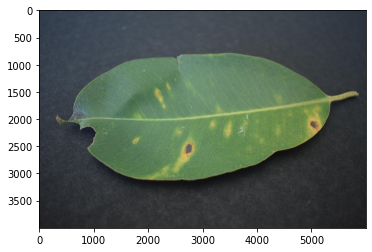

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

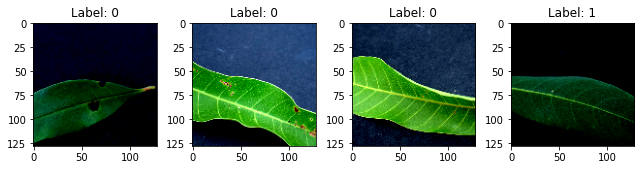

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[10:10:17] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[10:10:19] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.262285038304068 samples/sec                   batch loss = 0.4107545018196106 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.274903091666685 samples/sec                   batch loss = 0.8292105197906494 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.2726226490690942 samples/sec                   batch loss = 0.8354880809783936 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2653148679332826 samples/sec                   batch loss = 1.086745023727417 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.267535654411537 samples/sec                   batch loss = 0.9733734726905823 | accuracy = 0.53


Epoch[1] Batch[30] Speed: 1.2593940828832328 samples/sec                   batch loss = 0.623748242855072 | accuracy = 0.5333333333333333


Epoch[1] Batch[35] Speed: 1.2628573131872913 samples/sec                   batch loss = 0.6454960703849792 | accuracy = 0.5642857142857143


Epoch[1] Batch[40] Speed: 1.2709731929394588 samples/sec                   batch loss = 0.7663087844848633 | accuracy = 0.55625


Epoch[1] Batch[45] Speed: 1.2661476461443255 samples/sec                   batch loss = 0.6502142548561096 | accuracy = 0.5666666666666667


Epoch[1] Batch[50] Speed: 1.2606059877449967 samples/sec                   batch loss = 0.45810648798942566 | accuracy = 0.565


Epoch[1] Batch[55] Speed: 1.263508986711524 samples/sec                   batch loss = 0.48640766739845276 | accuracy = 0.5681818181818182


Epoch[1] Batch[60] Speed: 1.2696787263024294 samples/sec                   batch loss = 0.8627581596374512 | accuracy = 0.5791666666666667


Epoch[1] Batch[65] Speed: 1.2623954052619322 samples/sec                   batch loss = 0.6396419405937195 | accuracy = 0.5846153846153846


Epoch[1] Batch[70] Speed: 1.2602178525584375 samples/sec                   batch loss = 0.36654800176620483 | accuracy = 0.5928571428571429


Epoch[1] Batch[75] Speed: 1.2663162258178757 samples/sec                   batch loss = 0.3190918266773224 | accuracy = 0.6033333333333334


Epoch[1] Batch[80] Speed: 1.2673247223036987 samples/sec                   batch loss = 0.9797521233558655 | accuracy = 0.59375


Epoch[1] Batch[85] Speed: 1.2680679404172197 samples/sec                   batch loss = 0.7392006516456604 | accuracy = 0.5941176470588235


Epoch[1] Batch[90] Speed: 1.268826040570298 samples/sec                   batch loss = 0.4313948452472687 | accuracy = 0.6


Epoch[1] Batch[95] Speed: 1.2603674347845064 samples/sec                   batch loss = 0.41345101594924927 | accuracy = 0.6052631578947368


Epoch[1] Batch[100] Speed: 1.2651063913857143 samples/sec                   batch loss = 0.5586000680923462 | accuracy = 0.61


Epoch[1] Batch[105] Speed: 1.2644174288846892 samples/sec                   batch loss = 0.40866899490356445 | accuracy = 0.6190476190476191


Epoch[1] Batch[110] Speed: 1.271389371148919 samples/sec                   batch loss = 0.32596904039382935 | accuracy = 0.6227272727272727


Epoch[1] Batch[115] Speed: 1.2603718849262304 samples/sec                   batch loss = 0.6740501523017883 | accuracy = 0.6239130434782608


Epoch[1] Batch[120] Speed: 1.2677905325974093 samples/sec                   batch loss = 0.4838535785675049 | accuracy = 0.625


Epoch[1] Batch[125] Speed: 1.2687522526358201 samples/sec                   batch loss = 0.5002179145812988 | accuracy = 0.632


Epoch[1] Batch[130] Speed: 1.2679308982400497 samples/sec                   batch loss = 0.29477474093437195 | accuracy = 0.6403846153846153


Epoch[1] Batch[135] Speed: 1.2672355066100924 samples/sec                   batch loss = 0.2667067050933838 | accuracy = 0.6444444444444445


Epoch[1] Batch[140] Speed: 1.2686365504781845 samples/sec                   batch loss = 0.6627166867256165 | accuracy = 0.6410714285714286


Epoch[1] Batch[145] Speed: 1.2686289720517308 samples/sec                   batch loss = 0.6575303673744202 | accuracy = 0.6379310344827587


Epoch[1] Batch[150] Speed: 1.269312929764555 samples/sec                   batch loss = 1.040429949760437 | accuracy = 0.6383333333333333


Epoch[1] Batch[155] Speed: 1.2698657405049107 samples/sec                   batch loss = 0.6580716371536255 | accuracy = 0.6419354838709678


Epoch[1] Batch[160] Speed: 1.2619201669200202 samples/sec                   batch loss = 0.28123700618743896 | accuracy = 0.65


Epoch[1] Batch[165] Speed: 1.2653697416030143 samples/sec                   batch loss = 0.48313382267951965 | accuracy = 0.6515151515151515


Epoch[1] Batch[170] Speed: 1.2663427018742188 samples/sec                   batch loss = 0.9372676610946655 | accuracy = 0.6529411764705882


Epoch[1] Batch[175] Speed: 1.2678114178032829 samples/sec                   batch loss = 0.6729322075843811 | accuracy = 0.6557142857142857


Epoch[1] Batch[180] Speed: 1.2674509092900756 samples/sec                   batch loss = 0.6446242928504944 | accuracy = 0.6541666666666667


Epoch[1] Batch[185] Speed: 1.2631325660775763 samples/sec                   batch loss = 0.6193512082099915 | accuracy = 0.6527027027027027


Epoch[1] Batch[190] Speed: 1.2702194497871158 samples/sec                   batch loss = 0.5913422107696533 | accuracy = 0.6539473684210526


Epoch[1] Batch[195] Speed: 1.2683332922581183 samples/sec                   batch loss = 0.8847152590751648 | accuracy = 0.6564102564102564


Epoch[1] Batch[200] Speed: 1.2631343729695585 samples/sec                   batch loss = 0.2371102124452591 | accuracy = 0.66


Epoch[1] Batch[205] Speed: 1.267167454585883 samples/sec                   batch loss = 0.6316264271736145 | accuracy = 0.6573170731707317


Epoch[1] Batch[210] Speed: 1.2656915402242486 samples/sec                   batch loss = 1.0411550998687744 | accuracy = 0.6583333333333333


Epoch[1] Batch[215] Speed: 1.270033677374267 samples/sec                   batch loss = 0.631174623966217 | accuracy = 0.6593023255813953


Epoch[1] Batch[220] Speed: 1.2636859067279693 samples/sec                   batch loss = 0.35433638095855713 | accuracy = 0.6625


Epoch[1] Batch[225] Speed: 1.2692115277147458 samples/sec                   batch loss = 0.5387488603591919 | accuracy = 0.6633333333333333


Epoch[1] Batch[230] Speed: 1.268906459041744 samples/sec                   batch loss = 0.4422663748264313 | accuracy = 0.6630434782608695


Epoch[1] Batch[235] Speed: 1.2688275759110548 samples/sec                   batch loss = 0.4899229407310486 | accuracy = 0.6648936170212766


Epoch[1] Batch[240] Speed: 1.2658977262575364 samples/sec                   batch loss = 0.8288469910621643 | accuracy = 0.6645833333333333


Epoch[1] Batch[245] Speed: 1.2667383496794613 samples/sec                   batch loss = 0.6439298391342163 | accuracy = 0.6642857142857143


Epoch[1] Batch[250] Speed: 1.2709228385461684 samples/sec                   batch loss = 0.427179753780365 | accuracy = 0.664


Epoch[1] Batch[255] Speed: 1.2678904620829532 samples/sec                   batch loss = 0.48354649543762207 | accuracy = 0.6666666666666666


Epoch[1] Batch[260] Speed: 1.255806524001936 samples/sec                   batch loss = 0.5400574803352356 | accuracy = 0.6663461538461538


Epoch[1] Batch[265] Speed: 1.257056173735709 samples/sec                   batch loss = 0.5587553977966309 | accuracy = 0.6613207547169812


Epoch[1] Batch[270] Speed: 1.261186600668149 samples/sec                   batch loss = 0.8170264363288879 | accuracy = 0.6601851851851852


Epoch[1] Batch[275] Speed: 1.2584553655024298 samples/sec                   batch loss = 0.32570570707321167 | accuracy = 0.6627272727272727


Epoch[1] Batch[280] Speed: 1.2619976239215764 samples/sec                   batch loss = 0.5183378458023071 | accuracy = 0.6651785714285714


Epoch[1] Batch[285] Speed: 1.2608293756160527 samples/sec                   batch loss = 0.2233482301235199 | accuracy = 0.6684210526315789


Epoch[1] Batch[290] Speed: 1.2634205928504283 samples/sec                   batch loss = 0.5623319149017334 | accuracy = 0.6681034482758621


Epoch[1] Batch[295] Speed: 1.2673038531297063 samples/sec                   batch loss = 0.7341629862785339 | accuracy = 0.6703389830508475


Epoch[1] Batch[300] Speed: 1.2627112259430717 samples/sec                   batch loss = 0.23982550203800201 | accuracy = 0.6708333333333333


Epoch[1] Batch[305] Speed: 1.2624580057709474 samples/sec                   batch loss = 0.38163700699806213 | accuracy = 0.671311475409836


Epoch[1] Batch[310] Speed: 1.2646621887080545 samples/sec                   batch loss = 0.34823471307754517 | accuracy = 0.6725806451612903


Epoch[1] Batch[315] Speed: 1.2679432595705735 samples/sec                   batch loss = 0.4492127299308777 | accuracy = 0.6738095238095239


Epoch[1] Batch[320] Speed: 1.2691832033326806 samples/sec                   batch loss = 0.42289143800735474 | accuracy = 0.6734375


Epoch[1] Batch[325] Speed: 1.2655259906213339 samples/sec                   batch loss = 0.7574992775917053 | accuracy = 0.6723076923076923


Epoch[1] Batch[330] Speed: 1.2651352019017277 samples/sec                   batch loss = 0.23718924820423126 | accuracy = 0.6742424242424242


Epoch[1] Batch[335] Speed: 1.2642806029283127 samples/sec                   batch loss = 0.6164445877075195 | accuracy = 0.673134328358209


Epoch[1] Batch[340] Speed: 1.2618155770883654 samples/sec                   batch loss = 0.38393232226371765 | accuracy = 0.675


Epoch[1] Batch[345] Speed: 1.2653863477906973 samples/sec                   batch loss = 0.5111541748046875 | accuracy = 0.6760869565217391


Epoch[1] Batch[350] Speed: 1.265110779657745 samples/sec                   batch loss = 0.4476403295993805 | accuracy = 0.6757142857142857


Epoch[1] Batch[355] Speed: 1.265264102098266 samples/sec                   batch loss = 0.8543380498886108 | accuracy = 0.6746478873239437


Epoch[1] Batch[360] Speed: 1.2675981911288612 samples/sec                   batch loss = 0.2670711576938629 | accuracy = 0.675


Epoch[1] Batch[365] Speed: 1.2703796884827105 samples/sec                   batch loss = 0.4779609441757202 | accuracy = 0.6767123287671233


Epoch[1] Batch[370] Speed: 1.267937414260209 samples/sec                   batch loss = 1.880823016166687 | accuracy = 0.6763513513513514


Epoch[1] Batch[375] Speed: 1.2736647152120237 samples/sec                   batch loss = 0.783094048500061 | accuracy = 0.676


Epoch[1] Batch[380] Speed: 1.2680118741279556 samples/sec                   batch loss = 0.5046376585960388 | accuracy = 0.6776315789473685


Epoch[1] Batch[385] Speed: 1.2584479082257718 samples/sec                   batch loss = 0.4046168029308319 | accuracy = 0.6779220779220779


Epoch[1] Batch[390] Speed: 1.2619188380838395 samples/sec                   batch loss = 0.2757589817047119 | accuracy = 0.6801282051282052


Epoch[1] Batch[395] Speed: 1.2653205936590282 samples/sec                   batch loss = 0.37702760100364685 | accuracy = 0.6797468354430379


Epoch[1] Batch[400] Speed: 1.2605264284893187 samples/sec                   batch loss = 0.9019848108291626 | accuracy = 0.68


Epoch[1] Batch[405] Speed: 1.263613191267993 samples/sec                   batch loss = 0.3259274363517761 | accuracy = 0.6796296296296296


Epoch[1] Batch[410] Speed: 1.2585021878918001 samples/sec                   batch loss = 0.5341671109199524 | accuracy = 0.6798780487804879


Epoch[1] Batch[415] Speed: 1.263094527446336 samples/sec                   batch loss = 0.641347348690033 | accuracy = 0.6819277108433734


Epoch[1] Batch[420] Speed: 1.259178385611042 samples/sec                   batch loss = 0.6746472716331482 | accuracy = 0.6815476190476191


Epoch[1] Batch[425] Speed: 1.2706424481511924 samples/sec                   batch loss = 0.49548983573913574 | accuracy = 0.6817647058823529


Epoch[1] Batch[430] Speed: 1.2703488110159185 samples/sec                   batch loss = 0.5436772108078003 | accuracy = 0.6808139534883721


Epoch[1] Batch[435] Speed: 1.2718224047238986 samples/sec                   batch loss = 1.267033576965332 | accuracy = 0.6810344827586207


Epoch[1] Batch[440] Speed: 1.269171585900901 samples/sec                   batch loss = 0.5986231565475464 | accuracy = 0.6823863636363636


Epoch[1] Batch[445] Speed: 1.2684077986305122 samples/sec                   batch loss = 0.7474191188812256 | accuracy = 0.6825842696629213


Epoch[1] Batch[450] Speed: 1.2700786731577094 samples/sec                   batch loss = 0.4726715385913849 | accuracy = 0.6811111111111111


Epoch[1] Batch[455] Speed: 1.2698838105712285 samples/sec                   batch loss = 1.4472237825393677 | accuracy = 0.6813186813186813


Epoch[1] Batch[460] Speed: 1.2724035550696329 samples/sec                   batch loss = 0.5173361301422119 | accuracy = 0.6826086956521739


Epoch[1] Batch[465] Speed: 1.2645101557844094 samples/sec                   batch loss = 0.5381993055343628 | accuracy = 0.6849462365591398


Epoch[1] Batch[470] Speed: 1.267408301617687 samples/sec                   batch loss = 1.2192339897155762 | accuracy = 0.6861702127659575


Epoch[1] Batch[475] Speed: 1.271882376085553 samples/sec                   batch loss = 0.7516669034957886 | accuracy = 0.6857894736842105


Epoch[1] Batch[480] Speed: 1.2638281258062667 samples/sec                   batch loss = 0.4109862446784973 | accuracy = 0.6875


Epoch[1] Batch[485] Speed: 1.267986478209687 samples/sec                   batch loss = 0.7258099913597107 | accuracy = 0.688659793814433


Epoch[1] Batch[490] Speed: 1.2731455943939516 samples/sec                   batch loss = 0.4824356436729431 | accuracy = 0.6877551020408164


Epoch[1] Batch[495] Speed: 1.2658804380492035 samples/sec                   batch loss = 0.4448530673980713 | accuracy = 0.6888888888888889


Epoch[1] Batch[500] Speed: 1.2682550556061112 samples/sec                   batch loss = 0.5013011693954468 | accuracy = 0.691


Epoch[1] Batch[505] Speed: 1.2664943153428334 samples/sec                   batch loss = 0.31948789954185486 | accuracy = 0.6915841584158415


Epoch[1] Batch[510] Speed: 1.2622880774111127 samples/sec                   batch loss = 1.0054233074188232 | accuracy = 0.6906862745098039


Epoch[1] Batch[515] Speed: 1.2711596255745508 samples/sec                   batch loss = 0.4858725666999817 | accuracy = 0.6902912621359223


Epoch[1] Batch[520] Speed: 1.2668385916488194 samples/sec                   batch loss = 0.17493730783462524 | accuracy = 0.6913461538461538


Epoch[1] Batch[525] Speed: 1.2696739219356976 samples/sec                   batch loss = 0.6122921109199524 | accuracy = 0.6914285714285714


Epoch[1] Batch[530] Speed: 1.265355617142727 samples/sec                   batch loss = 0.23588527739048004 | accuracy = 0.6919811320754717


Epoch[1] Batch[535] Speed: 1.2670487878115961 samples/sec                   batch loss = 0.5564014911651611 | accuracy = 0.6915887850467289


Epoch[1] Batch[540] Speed: 1.2639719005117676 samples/sec                   batch loss = 0.7849743962287903 | accuracy = 0.6893518518518519


Epoch[1] Batch[545] Speed: 1.270418167177518 samples/sec                   batch loss = 0.6072313785552979 | accuracy = 0.6894495412844037


Epoch[1] Batch[550] Speed: 1.2715418100483327 samples/sec                   batch loss = 0.49418574571609497 | accuracy = 0.6895454545454546


Epoch[1] Batch[555] Speed: 1.2695061762492579 samples/sec                   batch loss = 1.1226314306259155 | accuracy = 0.6891891891891891


Epoch[1] Batch[560] Speed: 1.2703009106267704 samples/sec                   batch loss = 0.30111780762672424 | accuracy = 0.6901785714285714


Epoch[1] Batch[565] Speed: 1.2663012200247974 samples/sec                   batch loss = 0.5534039735794067 | accuracy = 0.6915929203539823


Epoch[1] Batch[570] Speed: 1.2665240496058554 samples/sec                   batch loss = 0.17871496081352234 | accuracy = 0.6929824561403509


Epoch[1] Batch[575] Speed: 1.263527732747405 samples/sec                   batch loss = 0.3005189895629883 | accuracy = 0.6939130434782609


Epoch[1] Batch[580] Speed: 1.2709278449228916 samples/sec                   batch loss = 0.5841385126113892 | accuracy = 0.6948275862068966


Epoch[1] Batch[585] Speed: 1.2776736692720658 samples/sec                   batch loss = 0.47515934705734253 | accuracy = 0.6948717948717948


Epoch[1] Batch[590] Speed: 1.2642277289639758 samples/sec                   batch loss = 0.24438095092773438 | accuracy = 0.6953389830508474


Epoch[1] Batch[595] Speed: 1.266086590091689 samples/sec                   batch loss = 0.37474870681762695 | accuracy = 0.6949579831932773


Epoch[1] Batch[600] Speed: 1.2713225099919192 samples/sec                   batch loss = 0.6883894801139832 | accuracy = 0.6941666666666667


Epoch[1] Batch[605] Speed: 1.2623894210163875 samples/sec                   batch loss = 0.29231446981430054 | accuracy = 0.6950413223140496


Epoch[1] Batch[610] Speed: 1.2731722601821545 samples/sec                   batch loss = 0.2647577226161957 | accuracy = 0.6967213114754098


Epoch[1] Batch[615] Speed: 1.2714610572035674 samples/sec                   batch loss = 0.5085456371307373 | accuracy = 0.6955284552845529


Epoch[1] Batch[620] Speed: 1.2659890463966146 samples/sec                   batch loss = 0.8698243498802185 | accuracy = 0.6943548387096774


Epoch[1] Batch[625] Speed: 1.2661056037865708 samples/sec                   batch loss = 0.6532647609710693 | accuracy = 0.6944


Epoch[1] Batch[630] Speed: 1.2617558870341041 samples/sec                   batch loss = 0.3633691072463989 | accuracy = 0.6944444444444444


Epoch[1] Batch[635] Speed: 1.2619865173705014 samples/sec                   batch loss = 0.47337180376052856 | accuracy = 0.6956692913385827


Epoch[1] Batch[640] Speed: 1.2598160498513389 samples/sec                   batch loss = 0.33678433299064636 | accuracy = 0.69609375


Epoch[1] Batch[645] Speed: 1.2654349281640915 samples/sec                   batch loss = 0.4279802441596985 | accuracy = 0.6965116279069767


Epoch[1] Batch[650] Speed: 1.2658794829133369 samples/sec                   batch loss = 0.6032696962356567 | accuracy = 0.6965384615384616


Epoch[1] Batch[655] Speed: 1.2693451974511132 samples/sec                   batch loss = 0.2560349106788635 | accuracy = 0.6969465648854962


Epoch[1] Batch[660] Speed: 1.2684038669300668 samples/sec                   batch loss = 0.4676417410373688 | accuracy = 0.6977272727272728


Epoch[1] Batch[665] Speed: 1.2683339634476256 samples/sec                   batch loss = 0.5431016087532043 | accuracy = 0.6973684210526315


Epoch[1] Batch[670] Speed: 1.271291490344841 samples/sec                   batch loss = 0.379219651222229 | accuracy = 0.6985074626865672


Epoch[1] Batch[675] Speed: 1.2666845048661441 samples/sec                   batch loss = 0.6488081812858582 | accuracy = 0.6988888888888889


Epoch[1] Batch[680] Speed: 1.2671416139597829 samples/sec                   batch loss = 0.285619854927063 | accuracy = 0.7


Epoch[1] Batch[685] Speed: 1.260926125801935 samples/sec                   batch loss = 0.3742591440677643 | accuracy = 0.7007299270072993


Epoch[1] Batch[690] Speed: 1.263534393909326 samples/sec                   batch loss = 0.2702259421348572 | accuracy = 0.702536231884058


Epoch[1] Batch[695] Speed: 1.262231761335714 samples/sec                   batch loss = 0.852752149105072 | accuracy = 0.7035971223021583


Epoch[1] Batch[700] Speed: 1.266752600671445 samples/sec                   batch loss = 0.24033279716968536 | accuracy = 0.7046428571428571


Epoch[1] Batch[705] Speed: 1.2615021012984349 samples/sec                   batch loss = 0.4177594482898712 | accuracy = 0.7046099290780142


Epoch[1] Batch[710] Speed: 1.2633978541263788 samples/sec                   batch loss = 1.0219238996505737 | accuracy = 0.7049295774647887


Epoch[1] Batch[715] Speed: 1.268635399318967 samples/sec                   batch loss = 0.6048019528388977 | accuracy = 0.7048951048951049


Epoch[1] Batch[720] Speed: 1.2621124030643276 samples/sec                   batch loss = 0.4785080552101135 | accuracy = 0.7045138888888889


Epoch[1] Batch[725] Speed: 1.2701760787972964 samples/sec                   batch loss = 0.8543288111686707 | accuracy = 0.7048275862068966


Epoch[1] Batch[730] Speed: 1.2627032429688385 samples/sec                   batch loss = 0.588466227054596 | accuracy = 0.7051369863013699


Epoch[1] Batch[735] Speed: 1.2673280729231897 samples/sec                   batch loss = 0.45129358768463135 | accuracy = 0.7054421768707483


Epoch[1] Batch[740] Speed: 1.263221775654189 samples/sec                   batch loss = 1.2956668138504028 | accuracy = 0.7047297297297297


Epoch[1] Batch[745] Speed: 1.265315631360388 samples/sec                   batch loss = 0.39087235927581787 | accuracy = 0.7036912751677852


Epoch[1] Batch[750] Speed: 1.2640857056705084 samples/sec                   batch loss = 0.41788381338119507 | accuracy = 0.704


Epoch[1] Batch[755] Speed: 1.265157812397844 samples/sec                   batch loss = 0.7423803210258484 | accuracy = 0.7039735099337748


Epoch[1] Batch[760] Speed: 1.2682319507941107 samples/sec                   batch loss = 0.425802618265152 | accuracy = 0.7042763157894737


Epoch[1] Batch[765] Speed: 1.2625761942167424 samples/sec                   batch loss = 0.6496288180351257 | accuracy = 0.7045751633986929


Epoch[1] Batch[770] Speed: 1.2614877784935081 samples/sec                   batch loss = 0.37500590085983276 | accuracy = 0.7051948051948052


Epoch[1] Batch[775] Speed: 1.2658348796736714 samples/sec                   batch loss = 0.27783364057540894 | accuracy = 0.7051612903225807


Epoch[1] Batch[780] Speed: 1.263017030824235 samples/sec                   batch loss = 0.5877828598022461 | accuracy = 0.7057692307692308


Epoch[1] Batch[785] Speed: 1.260357682456155 samples/sec                   batch loss = 0.6375636458396912 | accuracy = 0.7070063694267515


[Epoch 1] training: accuracy=0.7074873096446701
[Epoch 1] time cost: 649.9033720493317
[Epoch 1] validation: validation accuracy=0.7622222222222222


Epoch[2] Batch[5] Speed: 1.2671761640714072 samples/sec                   batch loss = 0.43457019329071045 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2655710494298065 samples/sec                   batch loss = 0.23348362743854523 | accuracy = 0.825


Epoch[2] Batch[15] Speed: 1.2611778785166898 samples/sec                   batch loss = 0.36717769503593445 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.264762769759374 samples/sec                   batch loss = 0.2821143567562103 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.262478715651946 samples/sec                   batch loss = 0.15340088307857513 | accuracy = 0.74


Epoch[2] Batch[30] Speed: 1.2646019430765347 samples/sec                   batch loss = 0.7119935154914856 | accuracy = 0.725


Epoch[2] Batch[35] Speed: 1.26453493608705 samples/sec                   batch loss = 0.422940731048584 | accuracy = 0.7214285714285714


Epoch[2] Batch[40] Speed: 1.2622233096096789 samples/sec                   batch loss = 0.5937713384628296 | accuracy = 0.725


Epoch[2] Batch[45] Speed: 1.2621636759282073 samples/sec                   batch loss = 0.6052461266517639 | accuracy = 0.7277777777777777


Epoch[2] Batch[50] Speed: 1.261373018092128 samples/sec                   batch loss = 0.39071595668792725 | accuracy = 0.74


Epoch[2] Batch[55] Speed: 1.2659935363248387 samples/sec                   batch loss = 0.6189419031143188 | accuracy = 0.740909090909091


Epoch[2] Batch[60] Speed: 1.2691448954169837 samples/sec                   batch loss = 0.48078709840774536 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.2688556924957193 samples/sec                   batch loss = 0.28718090057373047 | accuracy = 0.7538461538461538


Epoch[2] Batch[70] Speed: 1.263842406598563 samples/sec                   batch loss = 0.5937656760215759 | accuracy = 0.7535714285714286


Epoch[2] Batch[75] Speed: 1.2628085503164057 samples/sec                   batch loss = 0.8805384039878845 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.2678732152176684 samples/sec                   batch loss = 0.5544434785842896 | accuracy = 0.753125


Epoch[2] Batch[85] Speed: 1.262949526179838 samples/sec                   batch loss = 1.1173995733261108 | accuracy = 0.7470588235294118


Epoch[2] Batch[90] Speed: 1.2621595929363907 samples/sec                   batch loss = 0.3400457799434662 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.2681832512921478 samples/sec                   batch loss = 0.5478668808937073 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2666163207568466 samples/sec                   batch loss = 0.6579062938690186 | accuracy = 0.735


Epoch[2] Batch[105] Speed: 1.2633429610820528 samples/sec                   batch loss = 0.34045055508613586 | accuracy = 0.7357142857142858


Epoch[2] Batch[110] Speed: 1.2650359924006827 samples/sec                   batch loss = 0.41552555561065674 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.2696084900805782 samples/sec                   batch loss = 0.38399985432624817 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.262472635616425 samples/sec                   batch loss = 0.6361395716667175 | accuracy = 0.7375


Epoch[2] Batch[125] Speed: 1.2656174480812719 samples/sec                   batch loss = 0.381344199180603 | accuracy = 0.74


Epoch[2] Batch[130] Speed: 1.2666856524876007 samples/sec                   batch loss = 0.39740708470344543 | accuracy = 0.7346153846153847


Epoch[2] Batch[135] Speed: 1.2625484502468098 samples/sec                   batch loss = 0.35955026745796204 | accuracy = 0.7314814814814815


Epoch[2] Batch[140] Speed: 1.2708554488523058 samples/sec                   batch loss = 0.5333627462387085 | accuracy = 0.7321428571428571


Epoch[2] Batch[145] Speed: 1.2647501843351356 samples/sec                   batch loss = 0.2300465703010559 | accuracy = 0.7344827586206897


Epoch[2] Batch[150] Speed: 1.2686428818912237 samples/sec                   batch loss = 0.5047162175178528 | accuracy = 0.735


Epoch[2] Batch[155] Speed: 1.2666288477215697 samples/sec                   batch loss = 0.4507178068161011 | accuracy = 0.7370967741935484


Epoch[2] Batch[160] Speed: 1.265819121250511 samples/sec                   batch loss = 0.4593564569950104 | accuracy = 0.7390625


Epoch[2] Batch[165] Speed: 1.2637743377190618 samples/sec                   batch loss = 0.2269635647535324 | accuracy = 0.7393939393939394


Epoch[2] Batch[170] Speed: 1.2675475292094283 samples/sec                   batch loss = 1.0110752582550049 | accuracy = 0.7382352941176471


Epoch[2] Batch[175] Speed: 1.2620044588194073 samples/sec                   batch loss = 0.10514053702354431 | accuracy = 0.7414285714285714


Epoch[2] Batch[180] Speed: 1.26211287779396 samples/sec                   batch loss = 0.6167954206466675 | accuracy = 0.7375


Epoch[2] Batch[185] Speed: 1.2611293400515524 samples/sec                   batch loss = 0.4206658601760864 | accuracy = 0.7378378378378379


Epoch[2] Batch[190] Speed: 1.269000709411958 samples/sec                   batch loss = 0.19843710958957672 | accuracy = 0.7407894736842106


Epoch[2] Batch[195] Speed: 1.2705407373570063 samples/sec                   batch loss = 0.2650434076786041 | accuracy = 0.7410256410256411


Epoch[2] Batch[200] Speed: 1.2737643157133436 samples/sec                   batch loss = 0.5564013719558716 | accuracy = 0.7425


Epoch[2] Batch[205] Speed: 1.2659284832429807 samples/sec                   batch loss = 0.13346248865127563 | accuracy = 0.7451219512195122


Epoch[2] Batch[210] Speed: 1.2688683597601245 samples/sec                   batch loss = 0.3838508427143097 | accuracy = 0.7428571428571429


Epoch[2] Batch[215] Speed: 1.2657269662083843 samples/sec                   batch loss = 0.20815791189670563 | accuracy = 0.7441860465116279


Epoch[2] Batch[220] Speed: 1.2618605618783572 samples/sec                   batch loss = 0.5258786678314209 | accuracy = 0.740909090909091


Epoch[2] Batch[225] Speed: 1.2621203785695516 samples/sec                   batch loss = 0.238254576921463 | accuracy = 0.74


Epoch[2] Batch[230] Speed: 1.2657325046816486 samples/sec                   batch loss = 0.7463820576667786 | accuracy = 0.7402173913043478


Epoch[2] Batch[235] Speed: 1.2689924547468232 samples/sec                   batch loss = 1.1472359895706177 | accuracy = 0.7404255319148936


Epoch[2] Batch[240] Speed: 1.2656578348620309 samples/sec                   batch loss = 0.7787759304046631 | accuracy = 0.7395833333333334


Epoch[2] Batch[245] Speed: 1.2650195861749474 samples/sec                   batch loss = 0.49318572878837585 | accuracy = 0.7418367346938776


Epoch[2] Batch[250] Speed: 1.2655820282273134 samples/sec                   batch loss = 0.24679169058799744 | accuracy = 0.743


Epoch[2] Batch[255] Speed: 1.264396655349519 samples/sec                   batch loss = 1.6014790534973145 | accuracy = 0.7421568627450981


Epoch[2] Batch[260] Speed: 1.2609388247738482 samples/sec                   batch loss = 0.3169184923171997 | accuracy = 0.7451923076923077


Epoch[2] Batch[265] Speed: 1.2630068571272848 samples/sec                   batch loss = 0.5467138290405273 | accuracy = 0.7462264150943396


Epoch[2] Batch[270] Speed: 1.2696792067411022 samples/sec                   batch loss = 0.5277730822563171 | accuracy = 0.7481481481481481


Epoch[2] Batch[275] Speed: 1.26005988305485 samples/sec                   batch loss = 0.3533956706523895 | accuracy = 0.7463636363636363


Epoch[2] Batch[280] Speed: 1.2653187805069355 samples/sec                   batch loss = 0.18294373154640198 | accuracy = 0.7491071428571429


Epoch[2] Batch[285] Speed: 1.2636168078077663 samples/sec                   batch loss = 0.34113892912864685 | accuracy = 0.7491228070175439


Epoch[2] Batch[290] Speed: 1.2664377189317433 samples/sec                   batch loss = 0.39788538217544556 | accuracy = 0.7508620689655172


Epoch[2] Batch[295] Speed: 1.2670595051878006 samples/sec                   batch loss = 0.37344107031822205 | accuracy = 0.7508474576271187


Epoch[2] Batch[300] Speed: 1.2621823820656703 samples/sec                   batch loss = 0.2600555717945099 | accuracy = 0.7541666666666667


Epoch[2] Batch[305] Speed: 1.2655992128145155 samples/sec                   batch loss = 0.7830307483673096 | accuracy = 0.7540983606557377


Epoch[2] Batch[310] Speed: 1.264554284460074 samples/sec                   batch loss = 0.1179889664053917 | accuracy = 0.7564516129032258


Epoch[2] Batch[315] Speed: 1.266827973666144 samples/sec                   batch loss = 0.22879858314990997 | accuracy = 0.7579365079365079


Epoch[2] Batch[320] Speed: 1.2650958978151683 samples/sec                   batch loss = 0.2752012312412262 | accuracy = 0.7609375


Epoch[2] Batch[325] Speed: 1.2651174575214212 samples/sec                   batch loss = 0.5102831721305847 | accuracy = 0.7576923076923077


Epoch[2] Batch[330] Speed: 1.260808909311003 samples/sec                   batch loss = 0.36115336418151855 | accuracy = 0.759090909090909


Epoch[2] Batch[335] Speed: 1.2594219720175759 samples/sec                   batch loss = 0.8576997518539429 | accuracy = 0.7597014925373134


Epoch[2] Batch[340] Speed: 1.2665732910860796 samples/sec                   batch loss = 0.339431494474411 | accuracy = 0.7610294117647058


Epoch[2] Batch[345] Speed: 1.2622854181916483 samples/sec                   batch loss = 0.18536783754825592 | accuracy = 0.7601449275362319


Epoch[2] Batch[350] Speed: 1.2634132668959863 samples/sec                   batch loss = 0.28843480348587036 | accuracy = 0.7592857142857142


Epoch[2] Batch[355] Speed: 1.262950762115518 samples/sec                   batch loss = 0.3844904601573944 | accuracy = 0.7598591549295775


Epoch[2] Batch[360] Speed: 1.265281373475905 samples/sec                   batch loss = 0.24273525178432465 | accuracy = 0.7604166666666666


Epoch[2] Batch[365] Speed: 1.2694740924913128 samples/sec                   batch loss = 0.5952227115631104 | accuracy = 0.7589041095890411


Epoch[2] Batch[370] Speed: 1.2612602697379767 samples/sec                   batch loss = 0.14926570653915405 | accuracy = 0.7587837837837837


Epoch[2] Batch[375] Speed: 1.259396068170606 samples/sec                   batch loss = 0.39709609746932983 | accuracy = 0.7593333333333333


Epoch[2] Batch[380] Speed: 1.2631083161854364 samples/sec                   batch loss = 0.426570862531662 | accuracy = 0.7592105263157894


Epoch[2] Batch[385] Speed: 1.2643275739609297 samples/sec                   batch loss = 0.7569113373756409 | accuracy = 0.7564935064935064


Epoch[2] Batch[390] Speed: 1.2670692658131637 samples/sec                   batch loss = 0.45898276567459106 | accuracy = 0.7564102564102564


Epoch[2] Batch[395] Speed: 1.2645029124947664 samples/sec                   batch loss = 0.14995084702968597 | accuracy = 0.7588607594936709


Epoch[2] Batch[400] Speed: 1.2593628863321966 samples/sec                   batch loss = 0.9152272343635559 | accuracy = 0.75875


Epoch[2] Batch[405] Speed: 1.2627547539353419 samples/sec                   batch loss = 0.177131786942482 | accuracy = 0.7604938271604939


Epoch[2] Batch[410] Speed: 1.2674613462129178 samples/sec                   batch loss = 0.12663568556308746 | accuracy = 0.7621951219512195


Epoch[2] Batch[415] Speed: 1.2615558858603264 samples/sec                   batch loss = 0.5800430774688721 | accuracy = 0.7608433734939759


Epoch[2] Batch[420] Speed: 1.2680715825015176 samples/sec                   batch loss = 0.46290814876556396 | accuracy = 0.7613095238095238


Epoch[2] Batch[425] Speed: 1.2695364363692496 samples/sec                   batch loss = 0.2578333020210266 | accuracy = 0.7611764705882353


Epoch[2] Batch[430] Speed: 1.2626501207468424 samples/sec                   batch loss = 0.07613212615251541 | accuracy = 0.7616279069767442


Epoch[2] Batch[435] Speed: 1.2709255342825798 samples/sec                   batch loss = 0.6779782772064209 | accuracy = 0.7614942528735632


Epoch[2] Batch[440] Speed: 1.266595474906792 samples/sec                   batch loss = 0.47924065589904785 | accuracy = 0.7596590909090909


Epoch[2] Batch[445] Speed: 1.2671261100899915 samples/sec                   batch loss = 0.2024647295475006 | accuracy = 0.7606741573033707


Epoch[2] Batch[450] Speed: 1.26989130787735 samples/sec                   batch loss = 0.9886376857757568 | accuracy = 0.7611111111111111


Epoch[2] Batch[455] Speed: 1.2656666190894197 samples/sec                   batch loss = 0.7329031229019165 | accuracy = 0.7604395604395604


Epoch[2] Batch[460] Speed: 1.2673656968098708 samples/sec                   batch loss = 0.5665367841720581 | accuracy = 0.7597826086956522


Epoch[2] Batch[465] Speed: 1.2645410360028144 samples/sec                   batch loss = 0.5890308618545532 | accuracy = 0.7602150537634409


Epoch[2] Batch[470] Speed: 1.2690867178929242 samples/sec                   batch loss = 0.4249022901058197 | accuracy = 0.7611702127659574


Epoch[2] Batch[475] Speed: 1.2658280987283408 samples/sec                   batch loss = 0.24518366158008575 | accuracy = 0.7610526315789473


Epoch[2] Batch[480] Speed: 1.2684394449119767 samples/sec                   batch loss = 1.9455145597457886 | accuracy = 0.7609375


Epoch[2] Batch[485] Speed: 1.2704143192031438 samples/sec                   batch loss = 0.41056281328201294 | accuracy = 0.761340206185567


Epoch[2] Batch[490] Speed: 1.2639492371614223 samples/sec                   batch loss = 0.24734994769096375 | accuracy = 0.761734693877551


Epoch[2] Batch[495] Speed: 1.2689572296502407 samples/sec                   batch loss = 0.6011461615562439 | accuracy = 0.7621212121212121


Epoch[2] Batch[500] Speed: 1.2637999459895752 samples/sec                   batch loss = 0.230936661362648 | accuracy = 0.7615


Epoch[2] Batch[505] Speed: 1.2714601899852485 samples/sec                   batch loss = 0.5788694024085999 | accuracy = 0.7613861386138614


Epoch[2] Batch[510] Speed: 1.269507040804096 samples/sec                   batch loss = 0.3753823935985565 | accuracy = 0.7607843137254902


Epoch[2] Batch[515] Speed: 1.2694924395914915 samples/sec                   batch loss = 0.09892763942480087 | accuracy = 0.7611650485436893


Epoch[2] Batch[520] Speed: 1.2666757065040624 samples/sec                   batch loss = 0.33834129571914673 | accuracy = 0.7615384615384615


Epoch[2] Batch[525] Speed: 1.2691516159366838 samples/sec                   batch loss = 0.2526762783527374 | accuracy = 0.7614285714285715


Epoch[2] Batch[530] Speed: 1.2698793891245015 samples/sec                   batch loss = 0.8902962803840637 | accuracy = 0.7613207547169811


Epoch[2] Batch[535] Speed: 1.2659511221032884 samples/sec                   batch loss = 0.7498984336853027 | accuracy = 0.7602803738317757


Epoch[2] Batch[540] Speed: 1.272141899357636 samples/sec                   batch loss = 0.5877731442451477 | accuracy = 0.7601851851851852


Epoch[2] Batch[545] Speed: 1.2631083161854364 samples/sec                   batch loss = 0.44175225496292114 | accuracy = 0.7610091743119266


Epoch[2] Batch[550] Speed: 1.2676777835320523 samples/sec                   batch loss = 0.4711385667324066 | accuracy = 0.7609090909090909


Epoch[2] Batch[555] Speed: 1.2695486368891715 samples/sec                   batch loss = 0.6536821126937866 | accuracy = 0.7612612612612613


Epoch[2] Batch[560] Speed: 1.2601797999617077 samples/sec                   batch loss = 0.43516233563423157 | accuracy = 0.7620535714285714


Epoch[2] Batch[565] Speed: 1.2706733398942667 samples/sec                   batch loss = 0.8049301505088806 | accuracy = 0.7606194690265486


Epoch[2] Batch[570] Speed: 1.2633404876776377 samples/sec                   batch loss = 0.2815026640892029 | accuracy = 0.7618421052631579


Epoch[2] Batch[575] Speed: 1.2702206038228627 samples/sec                   batch loss = 0.7190870046615601 | accuracy = 0.7613043478260869


Epoch[2] Batch[580] Speed: 1.2630147488592587 samples/sec                   batch loss = 0.2641203701496124 | accuracy = 0.7625


Epoch[2] Batch[585] Speed: 1.2697915432835765 samples/sec                   batch loss = 0.2743546664714813 | accuracy = 0.7623931623931623


Epoch[2] Batch[590] Speed: 1.2679288859532414 samples/sec                   batch loss = 0.23562878370285034 | accuracy = 0.7614406779661017


Epoch[2] Batch[595] Speed: 1.2641977213839641 samples/sec                   batch loss = 0.1735621690750122 | accuracy = 0.7617647058823529


Epoch[2] Batch[600] Speed: 1.2785208518830906 samples/sec                   batch loss = 0.36121782660484314 | accuracy = 0.7616666666666667


Epoch[2] Batch[605] Speed: 1.265069664650388 samples/sec                   batch loss = 0.8334270715713501 | accuracy = 0.7611570247933884


Epoch[2] Batch[610] Speed: 1.2685189511735748 samples/sec                   batch loss = 0.30556198954582214 | accuracy = 0.7614754098360655


Epoch[2] Batch[615] Speed: 1.2648201700975392 samples/sec                   batch loss = 0.29011616110801697 | accuracy = 0.7613821138211382


Epoch[2] Batch[620] Speed: 1.2653047526111045 samples/sec                   batch loss = 0.4373118281364441 | accuracy = 0.7616935483870968


Epoch[2] Batch[625] Speed: 1.267487965932006 samples/sec                   batch loss = 0.5004914402961731 | accuracy = 0.7616


Epoch[2] Batch[630] Speed: 1.2645572391898405 samples/sec                   batch loss = 0.248228520154953 | accuracy = 0.7615079365079365


Epoch[2] Batch[635] Speed: 1.2654140257387798 samples/sec                   batch loss = 0.7777001857757568 | accuracy = 0.7622047244094489


Epoch[2] Batch[640] Speed: 1.2708746060525031 samples/sec                   batch loss = 0.6715869903564453 | accuracy = 0.762109375


Epoch[2] Batch[645] Speed: 1.2699892615868658 samples/sec                   batch loss = 0.42519837617874146 | accuracy = 0.7612403100775194


Epoch[2] Batch[650] Speed: 1.270188772438962 samples/sec                   batch loss = 0.9348508715629578 | accuracy = 0.7611538461538462


Epoch[2] Batch[655] Speed: 1.264676583687955 samples/sec                   batch loss = 0.15754763782024384 | accuracy = 0.7614503816793893


Epoch[2] Batch[660] Speed: 1.2686855726135622 samples/sec                   batch loss = 0.5581088066101074 | accuracy = 0.7609848484848485


Epoch[2] Batch[665] Speed: 1.2751269239237772 samples/sec                   batch loss = 0.35814622044563293 | accuracy = 0.76203007518797


Epoch[2] Batch[670] Speed: 1.2713532421287863 samples/sec                   batch loss = 0.42631348967552185 | accuracy = 0.7608208955223881


Epoch[2] Batch[675] Speed: 1.2673825469083009 samples/sec                   batch loss = 0.18347153067588806 | accuracy = 0.7618518518518519


Epoch[2] Batch[680] Speed: 1.2662043121939484 samples/sec                   batch loss = 0.5491369962692261 | accuracy = 0.7625


Epoch[2] Batch[685] Speed: 1.2737204122133463 samples/sec                   batch loss = 0.11655709147453308 | accuracy = 0.7635036496350365


Epoch[2] Batch[690] Speed: 1.2615079822794133 samples/sec                   batch loss = 0.8275948166847229 | accuracy = 0.7634057971014493


Epoch[2] Batch[695] Speed: 1.2674015038046107 samples/sec                   batch loss = 0.2527390420436859 | accuracy = 0.7643884892086331


Epoch[2] Batch[700] Speed: 1.2702302208689695 samples/sec                   batch loss = 0.29951122403144836 | accuracy = 0.7639285714285714


Epoch[2] Batch[705] Speed: 1.2750192614574323 samples/sec                   batch loss = 0.21609903872013092 | accuracy = 0.7641843971631206


Epoch[2] Batch[710] Speed: 1.265442468477862 samples/sec                   batch loss = 0.8571215271949768 | accuracy = 0.7644366197183099


Epoch[2] Batch[715] Speed: 1.2721960162131056 samples/sec                   batch loss = 1.2540494203567505 | accuracy = 0.7643356643356644


Epoch[2] Batch[720] Speed: 1.2636734379067323 samples/sec                   batch loss = 0.5138830542564392 | accuracy = 0.7642361111111111


Epoch[2] Batch[725] Speed: 1.2691217581720646 samples/sec                   batch loss = 0.45222043991088867 | accuracy = 0.7644827586206897


Epoch[2] Batch[730] Speed: 1.2657257248330953 samples/sec                   batch loss = 0.3001571595668793 | accuracy = 0.7640410958904109


Epoch[2] Batch[735] Speed: 1.2689142327278393 samples/sec                   batch loss = 0.24152079224586487 | accuracy = 0.7646258503401361


Epoch[2] Batch[740] Speed: 1.2644817549397023 samples/sec                   batch loss = 0.18926608562469482 | accuracy = 0.7658783783783784


Epoch[2] Batch[745] Speed: 1.261052653099758 samples/sec                   batch loss = 0.4690423607826233 | accuracy = 0.7664429530201342


Epoch[2] Batch[750] Speed: 1.2673011727351484 samples/sec                   batch loss = 0.1836983859539032 | accuracy = 0.7673333333333333


Epoch[2] Batch[755] Speed: 1.261289948384533 samples/sec                   batch loss = 0.2185872197151184 | accuracy = 0.7685430463576159


Epoch[2] Batch[760] Speed: 1.2641226610415175 samples/sec                   batch loss = 0.07025440782308578 | accuracy = 0.7694078947368421


Epoch[2] Batch[765] Speed: 1.2649020842531407 samples/sec                   batch loss = 0.5956051349639893 | accuracy = 0.7696078431372549


Epoch[2] Batch[770] Speed: 1.2664463227898146 samples/sec                   batch loss = 0.6757036447525024 | accuracy = 0.7694805194805194


Epoch[2] Batch[775] Speed: 1.265770415877598 samples/sec                   batch loss = 0.10914187133312225 | accuracy = 0.7693548387096775


Epoch[2] Batch[780] Speed: 1.2727111767211476 samples/sec                   batch loss = 0.6949504613876343 | accuracy = 0.7701923076923077


Epoch[2] Batch[785] Speed: 1.2672885367420945 samples/sec                   batch loss = 0.37804222106933594 | accuracy = 0.7707006369426752


[Epoch 2] training: accuracy=0.7706218274111675
[Epoch 2] time cost: 640.1531684398651
[Epoch 2] validation: validation accuracy=0.8144444444444444


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8044444444444444

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)